# Boundary mapping

The purpose of this notebook is to mess around with all the different options available with boundary mapping

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('..', 'hypedsearch', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)


import database
import testing_utils
import operator
import collections


#Assumptions:
max_peptide_length = 20
ppm_tolerance = 20

import matplotlib.pyplot as plt

In [2]:
datasets = testing_utils.define_data()

dataset = datasets[0]

input_spectra_path = dataset[0]
input_spectra, boundaries = testing_utils.preprocess_input_spectra(input_spectra_path, ppm_tolerance)

correct_sequences = testing_utils.generate_truth_set(datasets[0])

path = dataset[2]
db = database.build(path)

Loading spectra...
Done


In [3]:
matched_masses_b, matched_masses_y, database = testing_utils.modified_match_masses(boundaries, db, max_peptide_length)
# matched_masses_b, matched_masses_y, database = match_masses(boundaries, db, max_peptide_length)
print('Finished matching masses')

On protein 279/279 [100%]
Sorting the set of protein masses...
Sorting the set of protein masses done
Performing Merge
Done
Finished matching masses


# Grabbing hits

In [4]:
spectrum_num = 100
correct_sequence = correct_sequences[spectrum_num]
print(correct_sequence)

input_spectrum = input_spectra[spectrum_num]

#Remember to add in abundance if it is helpful
b_hits, y_hits, b_set, y_set, misses = testing_utils.find_hits(boundaries, input_spectrum, spectrum_num, matched_masses_b, matched_masses_y)
correct_hits = testing_utils.append_correct_hits(correct_sequence, input_spectrum, ppm_tolerance)

DGPVQGTIHFEQKASGEPVVLSGQITGLTEGQHGFHVHQYG


# Writing hits

In [5]:
testing_utils.write_hits(b_hits, y_hits)

Done


# Clustering b hits

In [6]:
ion = 'b'
testing_utils.create_clusters(ion)
b_sorted_clusters = testing_utils.sort_clusters_by_post_prob(ion, boundaries, matched_masses_b, matched_masses_y)

# Printing data

In [7]:
b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('score', 'post_prob', 'pid', 'prior'), reverse = True)
testing_utils.write_b_sorted_cluster(b_sorted_clusters)
for i in range(0, 50):
    x = b_sorted_clusters[i]
    post_prob = x.post_prob
    score = x.score
    seq = x.seq
    indices = x.indices
    print(post_prob, score, seq)

0.4825931870875691 3 GSQANS
0.46677821156348764 3 GSQFFICT
0.4510763209393346 3 PVGSPSR
0.4305324715297014 3 SGQADDERVREYHLL
0.42809046908769893 3 GSGAVALCPE
0.42769607843137253 3 GSQYRVESMMLRIAKPM
0.42769607843137253 3 ANSWNLDWGDNGFFKIL
0.42649162917619293 3 GQGQSPSIRQ
0.42497691597414583 3 QGSPVVQMAEDAVDGER
0.4223938223938224 3 QGSPGAWAPLDPTSGSSA
0.42117433930093773 3 GQSTVPPCTASPEPVKAAEQ
0.416856336932205 3 GSQMEDARRPAEPSLGGLPQ
0.4107948442534909 3 GSAGLMLVEFFAPWCG
0.3996786444639205 3 PVPVDCSDEAGNSALQLA
0.3744369369369369 3 SNSQQAYQEAFEI
0.3462974111980735 3 GQVLPEMEIHLQTDAKKGT
0.3142857142857143 3 GSPGSAGLVQHLEEYAAT
0.31201298701298696 3 SSNGFLIDGYPREVKQGE
0.30300736790803023 3 VPEMKPSMFDVSRELGSSV
0.2988665811585478 3 GQVRLTYSTGESNTVVSPTV
0.17540849673202613 3 IFVGTPYYGYVYEDTLP
0.15911553616661975 3 QVNQSLASMPPMNPATTLP
0.14827579466745225 3 MAEVDAAMAARPHSIDGRVV
0.3698769395398609 2 GQS
0.3698769395398609 2 QGS
0.3698769395398609 2 GQS
0.3698769395398609 2 NAS
0.3698769395398609 2 

# Clustering y_hits

In [8]:
ion = 'y'
testing_utils.create_clusters(ion)
y_sorted_clusters = testing_utils.sort_clusters_by_post_prob(ion, boundaries, matched_masses_b, matched_masses_y)

# Printing data

In [9]:
testing_utils.write_y_sorted_cluster(y_sorted_clusters)  
y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('score', 'post_prob', 'pid', 'prior'), reverse = True)
for i in range(0, 50):
    x = y_sorted_clusters[i]
    post_prob = x.post_prob
    score = x.score
    seq = x.seq
    indices = x.indices
    print(post_prob, score, seq)

0.41561085972850675 3 YEAGEKRWGTDEVK
0.39088600688323677 3 SRPCTPPQ
0.387228531579996 3 DVHPSDLKPKGDDKDPSK
0.3844489981785064 3 GLGNKTYEHFNAMGK
0.35945075380221825 3 GRPSGEAFVELESEDEVK
0.3586080586080586 3 VVWTSEYDPLASNPGWKK
0.35402930402930405 3 VCPTEIIAFSDHAEDFRK
0.35402930402930405 3 VTVTVLDVNDNRPEFTMK
0.18003292889544734 3 TGLTEGQHGFHVHQYG
0.44019607843137254 2 FVK
0.44019607843137254 2 VFK
0.44019607843137254 2 FVK
0.44019607843137254 2 VFK
0.44019607843137254 2 FVK
0.44019607843137254 2 FVK
0.44019607843137254 2 VFK
0.44019607843137254 2 FVK
0.44019607843137254 2 FVK
0.44019607843137254 2 FVK
0.44019607843137254 2 FVK
0.44019607843137254 2 VFK
0.44019607843137254 2 FVK
0.44019607843137254 2 FVK
0.44019607843137254 2 FVK
0.44019607843137254 2 VFK
0.44019607843137254 2 FVK
0.44019607843137254 2 FVK
0.44019607843137254 2 FVK
0.44019607843137254 2 FVK
0.44019607843137254 2 FVK
0.44019607843137254 2 FVK
0.44019607843137254 2 VFK
0.44019607843137254 2 VFK
0.44019607843137254 2 FVK
0.44

# Plotting

In [10]:
from scoring import mass_comparisons
import gen_spectra
print("Collecting data...")
score_array = []
posterior_array = []
bscore_array = []
for cluster in b_sorted_clusters:
    score_array.append(mass_comparisons.optimized_compare_masses(input_spectrum.mz_values, gen_spectra.gen_spectrum(cluster.seq, ion='b')))
    posterior_array.append(cluster.post_prob)
    bscore_array.append(cluster.score)
for cluster in y_sorted_clusters:
    score_array.append(mass_comparisons.optimized_compare_masses(input_spectrum.mz_values, gen_spectra.gen_spectrum(cluster.seq, ion='y')))
    posterior_array.append(cluster.post_prob)
    bscore_array.append(cluster.score)
print("Done")


Done


Text(0.5, 1.0, 'Posterior probability vs Simple additive scoring')

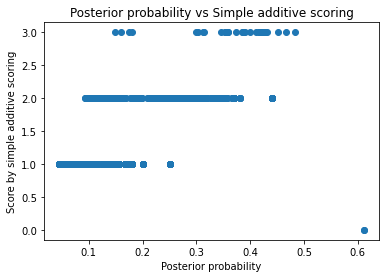

In [11]:
plt.scatter(posterior_array, score_array, s=None)
plt.ylabel('Score by simple additive scoring')
plt.xlabel('Posterior probability')
plt.title("Posterior probability vs Simple additive scoring")

Text(0.5, 1.0, 'Posterior probability vs cluster scoring')

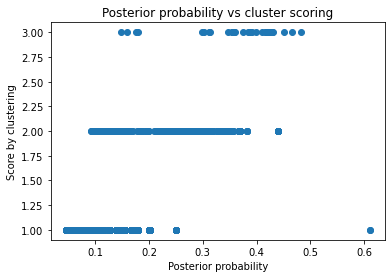

In [12]:
plt.scatter(posterior_array, bscore_array, s=None)
plt.xlabel("Posterior probability")
plt.ylabel("Score by clustering")
plt.title("Posterior probability vs cluster scoring")

# Probability of true positives

In [13]:
def calc_average(list):
    total = 0
    for x in list:
        total = total + x
    return total / len(list)

In [14]:
b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)


b_post_prob_array = []
b_score_array = []
y_post_prob_array = []
y_score_array = []
bad_clusters_prob = []
bad_clusters_score = []
for cluster in b_sorted_clusters:
    ion = 'b'
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        b_post_prob_array.append(cluster.post_prob)
        b_score_array.append(cluster.score)
    else:
        bad_clusters_prob.append(cluster.post_prob)
        bad_clusters_score.append(cluster.score)
for cluster in y_sorted_clusters:
    ion = 'y'
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        y_post_prob_array.append(cluster.post_prob)
        y_score_array.append(cluster.score)
    else:
        bad_clusters_prob.append(cluster.post_prob)
        bad_clusters_score.append(cluster.score)   

b_range = []
y_range = []
for i, x in enumerate(b_post_prob_array):
    b_range.append(i)
for i, x in enumerate(y_post_prob_array):
    y_range.append(i)
print('Average probability of b true positives in first spectrum:' ,calc_average(b_post_prob_array))
print('Average count of b true positives in first spectrum:' ,calc_average(b_score_array))
print('Average probability of y true positives in first spectrum:' ,calc_average(y_post_prob_array))
print('Average count of y true positives in first spectrum:' ,calc_average(y_score_array))
print('Average probability of false positives in the first spectrum:', calc_average(bad_clusters_prob))
print('Average count of false positives in the first spectrum:', calc_average(bad_clusters_score))
print('Number of true b positives', len(b_range))
print('Number of true y positives', len(y_range))
print('Number of bad clusters', len(bad_clusters_prob))

Average probability of b true positives in first spectrum: 0.16507283091362696
Average count of b true positives in first spectrum: 1.025
Average probability of y true positives in first spectrum: 0.14380090454393143
Average count of y true positives in first spectrum: 1.5
Average probability of false positives in the first spectrum: 0.1744254486915615
Average count of false positives in the first spectrum: 1.047832318165532
Number of true b positives 40
Number of true y positives 4
Number of bad clusters 16746


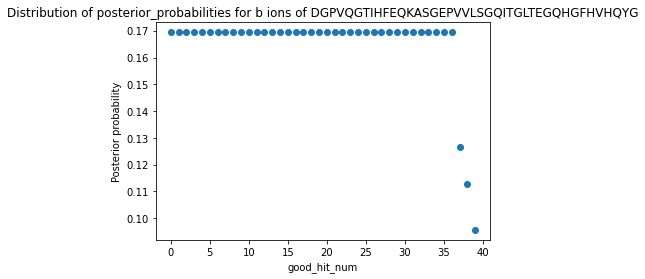

In [15]:
fig1, ax1 = plt.subplots()
ax1.scatter(x = b_range, y = b_post_prob_array)
plt.title("Distribution of posterior_probabilities for b ions of " + correct_sequence)
plt.xlabel("good_hit_num")
plt.ylabel("Posterior probability")
plt.show()

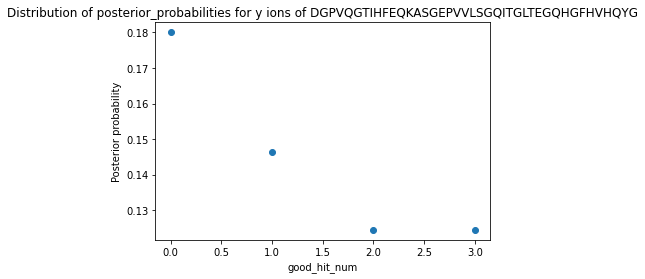

In [16]:
fig1, ax1 = plt.subplots()
ax1.scatter(x = y_range, y = y_post_prob_array)
plt.title("Distribution of posterior_probabilities for y ions of " + correct_sequence)
plt.xlabel("good_hit_num")
plt.ylabel("Posterior probability")
plt.show()

# Seed Location

Want to know where the good seeds rank compared to the bad seeds when sorted by score and sorted by posterior probability

Bottom is going to be enumerated array while vertical will be the score or posterior probability. The graph will be colored red or green depending on true or not

In [17]:
print("Collecting Data...")
b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
b_good_indexes = []
b_bad_indexes = []
b_good_cluster_prob = []
b_bad_cluster_prob = []
y_good_indexes = []
y_bad_indexes = []
y_good_cluster_prob = []
y_bad_cluster_prob = []
ion = 'b'
for i, cluster in enumerate(b_sorted_clusters):
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        b_good_indexes.append(i)
        b_good_cluster_prob.append(cluster.post_prob)
    else:
        b_bad_indexes.append(i)
        b_bad_cluster_prob.append(cluster.post_prob)
ion = 'y'
for i, cluster in enumerate(y_sorted_clusters):
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        y_good_indexes.append(i)
        y_good_cluster_prob.append(cluster.post_prob)
    else:
        y_bad_indexes.append(i)
        y_bad_cluster_prob.append(cluster.post_prob)
print('Done')

Done


No good hit found in the top 50 clusters


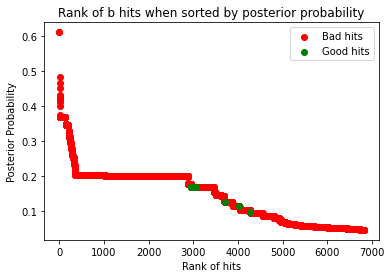

In [18]:
ion = 'b'
found = False
for i in range(0,50):
    target_cluster = b_sorted_clusters[i]
    assessment, _ = testing_utils.is_good_hit(target_cluster.seq, ion, correct_sequence)
    if assessment == True:
        print('Good hit found at:', i)
        found = True
if not found:
    print("No good hit found in the top 50 clusters")
plt.scatter(b_bad_indexes, b_bad_cluster_prob, color = 'r', label = 'Bad hits')
plt.scatter(b_good_indexes, b_good_cluster_prob, color = 'g', label = 'Good hits')
plt.title('Rank of b hits when sorted by posterior probability')
plt.xlabel('Rank of hits')
plt.ylabel('Posterior Probability')
plt.legend()

No good hit found in the top 50 clusters


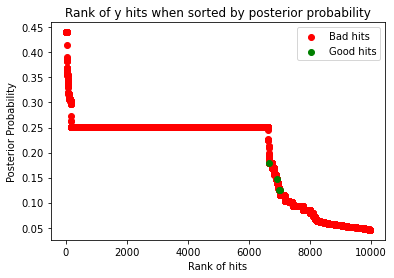

In [19]:
ion = 'y'
found = False
for i in range(0,50):
    target_cluster = y_sorted_clusters[i]
    assessment, _ = testing_utils.is_good_hit(target_cluster.seq, ion, correct_sequence)
    if assessment == True:
        print('Good hit found at:', i)
        found = True
if not found:
    print("No good hit found in the top 50 clusters")
plt.scatter(y_bad_indexes, y_bad_cluster_prob, color = 'r', label = 'Bad hits')
plt.scatter(y_good_indexes, y_good_cluster_prob, color = 'g', label = 'Good hits')
plt.title('Rank of y hits when sorted by posterior probability')
plt.xlabel('Rank of hits')
plt.ylabel('Posterior Probability')
plt.legend()

In [20]:
print("Collecting Data...")
b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('score', 'post_prob', 'pid', 'prior'), reverse = True)
y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('score', 'post_prob', 'pid', 'prior'), reverse = True)
b_good_indexes = []
b_bad_indexes = []
b_good_scores = []
b_bad_scores = []
y_good_indexes = []
y_bad_indexes = []
y_good_scores = []
y_bad_scores = []
ion = 'b'
for i, cluster in enumerate(b_sorted_clusters):
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        b_good_indexes.append(i)
        b_good_scores.append(cluster.score)
    else:
        b_bad_indexes.append(i)
        b_bad_scores.append(cluster.score)
ion = 'y'
for i, cluster in enumerate(y_sorted_clusters):
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        y_good_indexes.append(i)
        y_good_scores.append(cluster.score)
    else:
        y_bad_indexes.append(i)
        y_bad_scores.append(cluster.score)
print('Done')

Done


No good hit found in the top 50 clusters


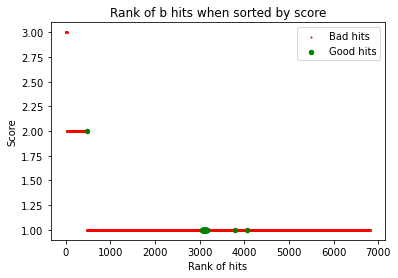

In [21]:
ion = 'b'
found = False
for i in range(0,50):
    target_cluster = b_sorted_clusters[i]
    assessment, _ = testing_utils.is_good_hit(target_cluster.seq, ion, correct_sequence)    
    if assessment == True:
        print('Good hit found at:', i)
        found = True
if found == False:
    print("No good hit found in the top 50 clusters")
plt.scatter(b_bad_indexes, b_bad_scores, color = 'r', label = 'Bad hits', s=1)
plt.scatter(b_good_indexes, b_good_scores, color = 'g', label = 'Good hits', s=20)
plt.title('Rank of b hits when sorted by score')
plt.xlabel('Rank of hits')
plt.ylabel('Score')
plt.legend()

Good hit found at: 8


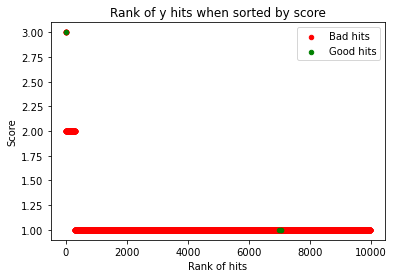

In [22]:
ion = 'y'
found = False
for i in range(0,50):
    target_cluster = y_sorted_clusters[i]
    assessment, _ = testing_utils.is_good_hit(target_cluster.seq, ion, correct_sequence)
    if assessment == True:
        print('Good hit found at:', i)
        found = True
if not found:
    print("No good hit found in the top 50 clusters")
plt.scatter(y_bad_indexes, y_bad_scores, color = 'r', label = 'Bad hits', s = 20)
plt.scatter(y_good_indexes, y_good_scores, color = 'g', label = 'Good hits', s = 20)
plt.title('Rank of y hits when sorted by score')
plt.xlabel('Rank of hits')
plt.ylabel('Score')
plt.legend()

# Distribution of size of seq vs weight

In [25]:
size_array = []
weight_array = []
prot_size_array = []
prot_weight_array = []
for seq in correct_sequences:
    size_array.append(len(seq))
    weight_array.append(gen_spectra.get_precursor(seq))

Text(0, 0.5, 'Weight of result')

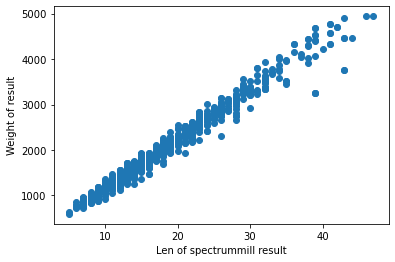

In [26]:
plt.scatter(size_array, weight_array)
plt.xlabel('Len of spectrummill result')
plt.ylabel('Weight of result')

Text(0, 0.5, 'Weight of Protein')

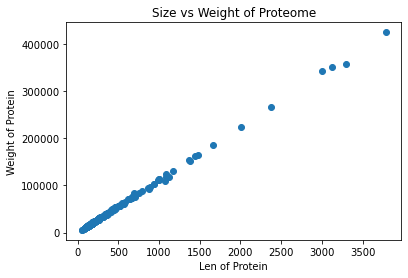

In [29]:
prot_size_array = []
prot_weight_array = []
for prot in db.proteins:
    target_prot = db.proteins[prot]
    if len(target_prot) != 0:
        target_prot = target_prot[0]
        seq = target_prot[1]
        prot_size_array.append(len(seq))
        prot_weight_array.append(gen_spectra.get_precursor(seq))
plt.scatter(prot_size_array, prot_weight_array)
plt.title('Size vs Weight of Proteome')
plt.xlabel('Len of Protein')
plt.ylabel('Weight of Protein')